### Загружаем необходимые библиотеки

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.0 MB/s eta 0:00:00


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

### Загружаем данные

In [66]:
temperature = pd.read_csv('mean-monthly-air-temperature-deg.csv')
temperature.head()

,Month,Deg
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


### Визуализируем временной ряд и проверим его на стационарность

In [67]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(dftest[1])

In [68]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
0.016989030222608604


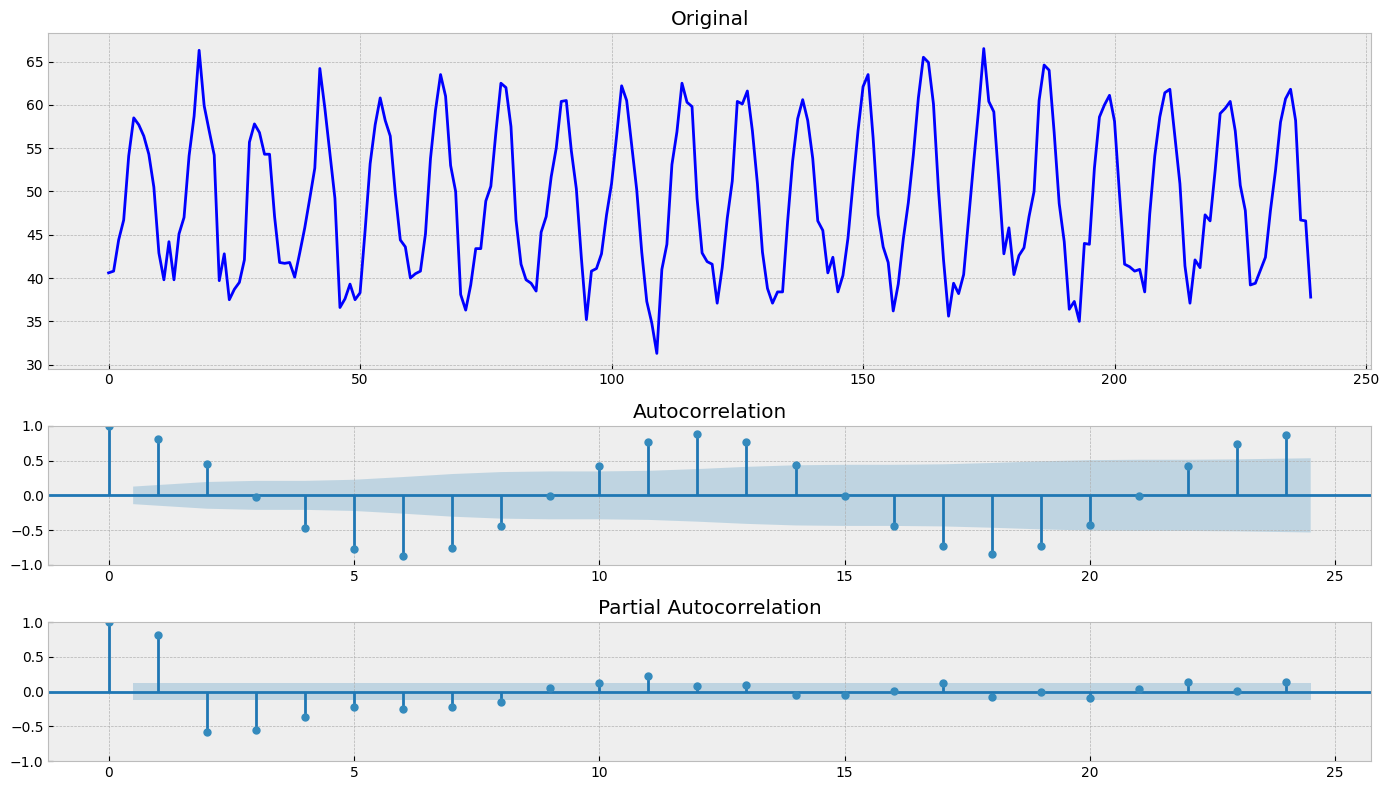

In [69]:
tsplot(temperature['Deg'])

Данный временной ряд нестационарен, имеет выраженную сезонность, равную 12

### Реализуем модель ARIMA и построим график ее остатков

Results of Dickey-Fuller Test:
0.48586541972337544


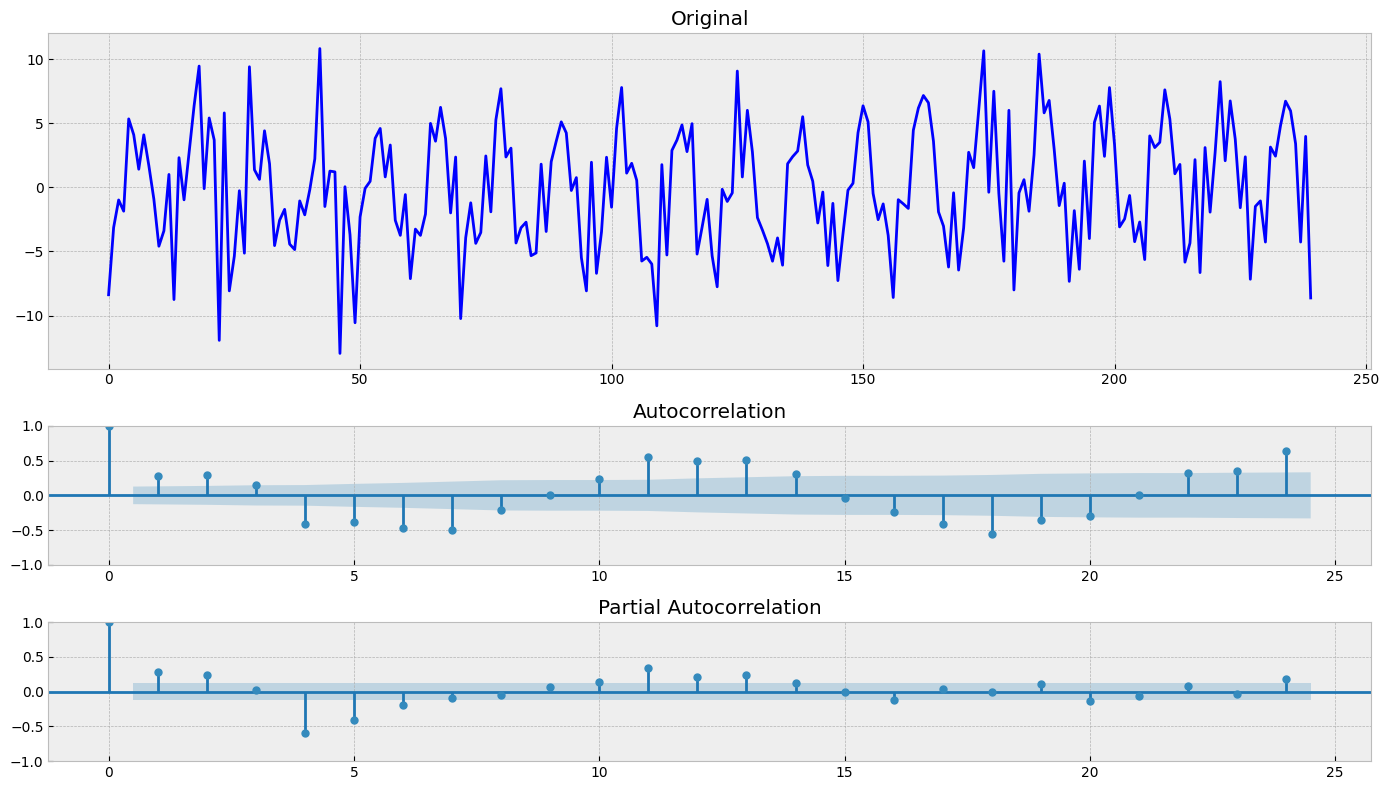

In [72]:
model = ARIMA(temperature['Deg'], order=(1,0,3)).fit()
tsplot(model.resid)

### Подберем оптимальные параметры для модели

In [60]:
auto_model = pm.auto_arima(temperature['Deg'],
                           start_p=3, max_p=5,
                           start_q=0, max_q=5,
                           d=None, max_d=2,
                           m=12,
                           trace=True,
                           error_action ='ignore',
                           suppress_warnings = True,
                           stepwise = True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=1625.649, Time=1.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1715.240, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1273.032, Time=0.92 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1457.718, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2558.757, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1459.276, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=4.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1149.164, Time=2.34 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1396.044, Time=0.32 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1132.991, Time=2.65 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=1131.409, Time=3.36 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=1139.066, Time=2.44 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=1342.509, Time=4.08 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.88 sec
 ARIMA(1,0,1)(2,0,2)[12] inte

### Реализуем модель ARIMA с подобранными параметрами и построим график ее остатков

Results of Dickey-Fuller Test:
5.947514911053823e-27


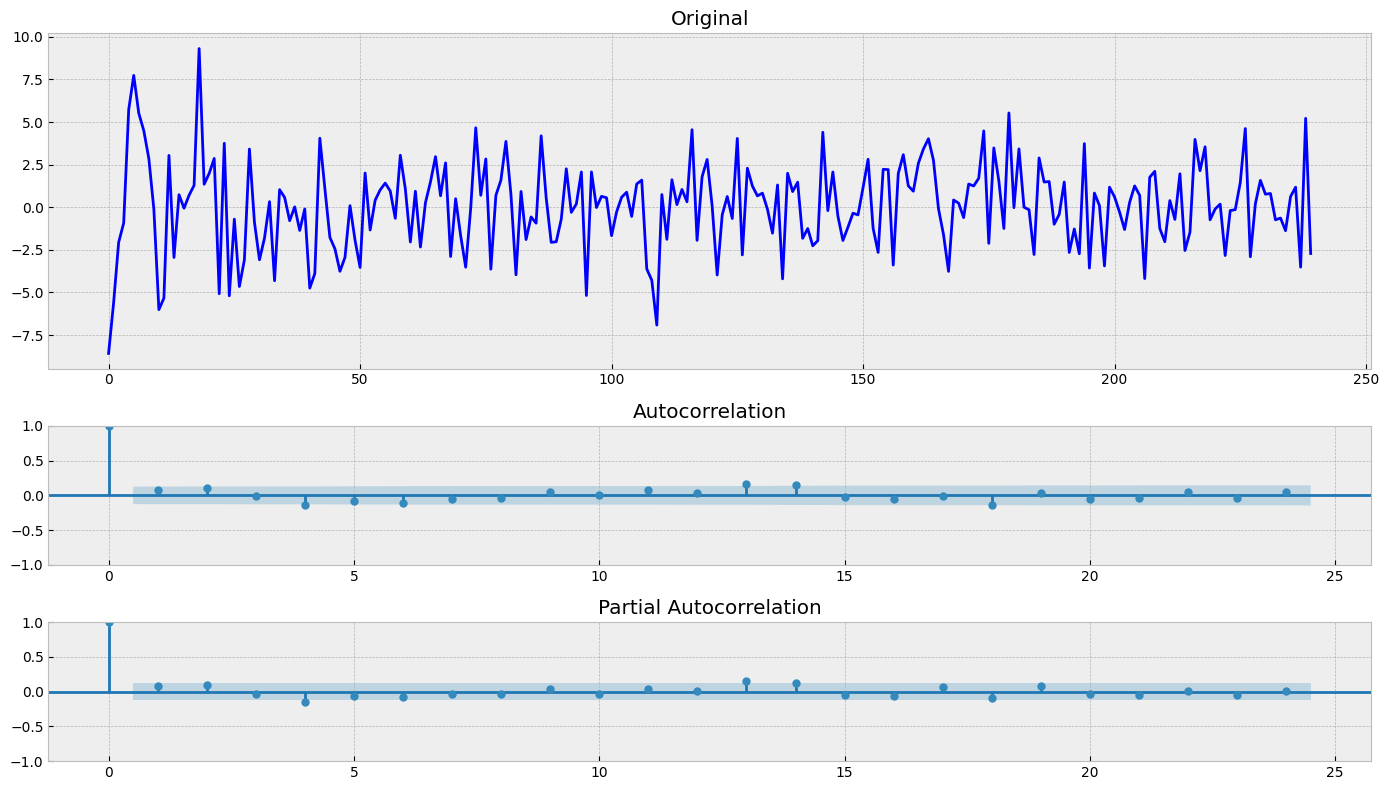

In [71]:
opt_model = ARIMA(temperature['Deg'], order=(1,0,0), seasonal_order=(2, 0, [1, 2], 12)).fit()
tsplot(opt_model.resid)

После подбора оптимальных параметров график остатков стал больше визуально похож на белый шум, из него исключилась сезонность, что подтверждается снижением общей и частичной автокорреляции до незначительных значений. Также значительно снизился p-value теста Дики-Фуллера